# Download Data

In [1]:
!gdown https://drive.google.com/uc?id=13q11ZnhYehDtibrHCvA7kfSkCKcxMpcv

import zipfile
with zipfile.ZipFile("fr-domain-classification.zip","r") as zip_ref:
    zip_ref.extractall("")
    

Downloading...
From: https://drive.google.com/uc?id=13q11ZnhYehDtibrHCvA7kfSkCKcxMpcv
To: /content/fr-domain-classification.zip
259MB [00:03, 79.0MB/s]


# Load Pretrained Node Embeddings Matrix 

In [2]:
!gdown https://drive.google.com/uc?id=1E6K2bW5I8X0zIrXmQRy-c02-lZVKMl6n

Downloading...
From: https://drive.google.com/uc?id=1E6K2bW5I8X0zIrXmQRy-c02-lZVKMl6n
To: /content/pretrained_embeddings.npy
57.4MB [00:00, 217MB/s]


#Install Dependencies

In [3]:
!pip install torch-scatter==latest+cu101 torch-sparse==latest+cu101 -f https://s3.eu-central-1.amazonaws.com/pytorch-geometric.com/whl/torch-1.4.0.html

Looking in links: https://s3.eu-central-1.amazonaws.com/pytorch-geometric.com/whl/torch-1.4.0.html
     |████████████████████████████████| 10.6MB 3.1MB/s 
     |████████████████████████████████| 11.5MB 68.5MB/s 


In [4]:

!pip install --upgrade torch-cluster
!pip install --upgrade torch-spline-conv 
!pip install torch-geometric



  Created wheel for torch-cluster: filename=torch_cluster-1.4.5-cp36-cp36m-linux_x86_64.whl size=20364221 sha256=eb23098969c830da314fac7bd30413a6862c8e2af1c28c8389232f2b78a90403
  Stored in directory: /root/.cache/pip/wheels/0a/26/7e/a6d6a80eae5ca39b92bc77773f36cf433d5085de18014382b1
Successfully built torch-cluster
  Created wheel for torch-spline-conv: filename=torch_spline_conv-1.1.1-cp36-cp36m-linux_x86_64.whl size=6895745 sha256=ed7261fccf0417e3b030897a6fb64495bf605a40c3613c34588fcce4a9143fca
  Stored in directory: /root/.cache/pip/wheels/63/cf/c7/3439a98ba262c5d99b91a9c11aaeced67f583febab5a4b1566
Successfully built torch-spline-conv
     |████████████████████████████████| 143kB 7.3MB/s 
     |████████████████████████████████| 348kB 11.6MB/s 
     |████████████████████████████████| 51kB 9.0MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-1.4.2-cp36-none-any.whl size=224447 sha256=42b3e532bba0799f64fd3fcdeedcc080751870ee427e30f01beb2d5699709d6d
  Stored in direct

#Load Dependencies

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import numpy as np
import os.path as osp
import torch
import torch.nn.functional as F
from torch_geometric.nn import SplineConv
from torch_geometric.data import Data
from random import shuffle, randint
import networkx as nx
import matplotlib.pyplot as plt
import random 
import csv




#Load Data

In [0]:
G = nx.read_weighted_edgelist('edgelist.txt', create_using=nx.DiGraph())
G.add_node('17591')

In [0]:
with open("train.csv") as f :
  train_data = f.read().splitlines()
train_hosts = list()

y_train = list()
for row in train_data:
    host, label = row.split(",")
    train_hosts.append(host)
    y_train.append(label.lower())


#Categorical Encoding Using Label Encoding

In [0]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(y_train)
le.classes_
y_train_num = le.transform(y_train)

# Labels Matrix

In [0]:
labels=np.zeros((G.number_of_nodes()))
for i,host in enumerate(train_hosts):
  labels[int(host)]=y_train_num[i]

# Train And Test Index

In [0]:
from sklearn.model_selection import train_test_split

idx = np.array([int(u) for u in train_hosts ], dtype=np.int32)
idx_train, idx_val = train_test_split(idx, test_size=0.2)


# Train And Test Mask

In [0]:
train_mask=np.array([False]*(G.number_of_nodes()+1))
train_mask[idx_train]=True

val_mask=np.array([False]*(G.number_of_nodes()+1))
val_mask[idx_val]=True

#Create a data structure 

In [0]:
from  torch_geometric.utils import from_networkx

In [0]:
G_ = nx.read_weighted_edgelist('edgelist.txt', create_using=nx.DiGraph(),nodetype = int)
G_.add_node(17591)
Lata = from_networkx(G_)

In [0]:
x = torch.tensor(np.load("pretrained_embeddings.npy"), dtype=torch.float)
y = torch.tensor(labels, dtype=torch.long)
data = Data(x = x, edge_index= Lata.edge_index, y =y, edge_attr=Lata.weight )


We will create a trian/test mask where we split the data into training and test. This is necessary because during optimizing the loss when training we don't want to include the nodes part of the testing process 

In [0]:
data.train_mask = torch.zeros(data.num_nodes, dtype=torch.uint8)
data.train_mask[idx_train] = 1 #train only on the 80% nodes
data.test_mask = torch.zeros(data.num_nodes, dtype=torch.uint8) #test on 20 % nodes 
data.test_mask[idx_val] = 1

# Deep GCN

We will use [SplineConv](https://arxiv.org/abs/1711.08920) layer for the convolution. We will illsue exponential ReLU as an activation function and dropout for regulaization

In [0]:
from torch.autograd import Variable
from torch.nn import  Parameter
import torch.nn as nn
from torch_geometric.nn import GATConv,ChebConv,GCNConv

class ChebNet(torch.nn.Module):
    def __init__(self):
        super(ChebNet, self).__init__()
        
        
        self.conv1 = ChebConv(256, 16, K=2)
        self.conv2 = ChebConv(16, 8, K=2)      

    def forward(self):
        x, edge_index, edge_weight = data.x, data.edge_index, data.edge_attr
        x = F.relu(self.conv1(x, edge_index, edge_weight))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index, edge_weight)
        return F.log_softmax(x, dim=1),x

class SplineNet(torch.nn.Module):
    def __init__(self):
        super(SplineNet, self).__init__()
        self.conv1 = SplineConv(256, 16, dim=1, kernel_size=2)
        self.conv2 = SplineConv(16, 8, dim=1, kernel_size=2)

    def forward(self):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        x = F.dropout(x, training=self.training)
        x = F.elu(self.conv1(x, edge_index, edge_attr))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index, edge_attr)
        return F.log_softmax(x, dim=1),x

class GATNet(torch.nn.Module):
    def __init__(self):
        super(GATNet, self).__init__()
        self.conv1 = GATConv(256, 8, heads=8, dropout=0.6)
        # On the Pubmed dataset, use heads=8 in conv2.
        self.conv2 = GATConv(8 * 8, 256, heads=1, concat=True, dropout=0.6)

    def forward(self):
        x = F.dropout(data.x, p=0.6, training=self.training)
        x = F.elu(self.conv1(x, data.edge_index))
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, data.edge_index)
        return F.log_softmax(x, dim=1),x


# Optimization 

We will use nll_loss which can be used for classification of arbitrary classes

In [0]:
def evaluate_loss(mode = 'train'):
  
  #use masking for loss evaluation 
  if mode == 'train':
    out,embdings=model()
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
  else:
    out,embdings=model()
    loss = F.nll_loss(out[data.test_mask], data.y[data.test_mask])
  return loss,embdings

def train():
  #training 
  model.train()
  optimizer.zero_grad()
  loss,embdings = evaluate_loss()
  loss.backward()
  optimizer.step()
  return loss.detach().cpu().numpy() ,embdings.detach().cpu().numpy() 

def test():
  #testing 
  model.eval()
  logits,_ = model() 
  accs=[]
  loss,embdings = evaluate_loss(mode = 'test')
  loss=loss.detach().cpu().numpy() 

  for _, mask in data('train_mask', 'test_mask'):
      pred = logits[mask].max(1)[1]
      acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
      accs.append(acc)
  return [loss] + accs

# Setup the model 
We will create the model and setup training using adam optimizer

In [0]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model, data = ChebNet().to(device), data.to(device)
optimizer =  torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-3)

# Training and Testing

In [22]:
from warnings import filterwarnings
filterwarnings("ignore")
    
losses = []
for epoch in range(1, 200):
  train_loss,embdings = train()
  log = 'Epoch: {:03d}, train_loss: {:.3f}, test_loss:{:.3f}, train_acc: {:.2f}, test_acc: {:.2f}'
  test_loss = test()[0]
  losses.append([train_loss,test_loss])
  print(log.format(epoch, train_loss, *test()))

Epoch: 001, train_loss: 2.405, test_loss:2.203, train_acc: 0.22, test_acc: 0.24
Epoch: 002, train_loss: 2.144, test_loss:2.120, train_acc: 0.25, test_acc: 0.24
Epoch: 003, train_loss: 2.095, test_loss:2.077, train_acc: 0.25, test_acc: 0.27
Epoch: 004, train_loss: 2.080, test_loss:2.057, train_acc: 0.27, test_acc: 0.28
Epoch: 005, train_loss: 2.011, test_loss:2.046, train_acc: 0.30, test_acc: 0.29
Epoch: 006, train_loss: 2.000, test_loss:2.035, train_acc: 0.32, test_acc: 0.31
Epoch: 007, train_loss: 1.979, test_loss:2.025, train_acc: 0.34, test_acc: 0.32
Epoch: 008, train_loss: 1.960, test_loss:2.018, train_acc: 0.34, test_acc: 0.33
Epoch: 009, train_loss: 1.943, test_loss:2.010, train_acc: 0.35, test_acc: 0.33
Epoch: 010, train_loss: 1.930, test_loss:2.000, train_acc: 0.37, test_acc: 0.33
Epoch: 011, train_loss: 1.921, test_loss:1.981, train_acc: 0.37, test_acc: 0.34
Epoch: 012, train_loss: 1.896, test_loss:1.965, train_acc: 0.38, test_acc: 0.34
Epoch: 013, train_loss: 1.887, test_loss

#T-SNE Visualization

In [0]:
out,embdings=model()

In [0]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, perplexity=10)
embeddings_test_2d = tsne.fit_transform(embdings.detach().cpu().numpy()[idx])

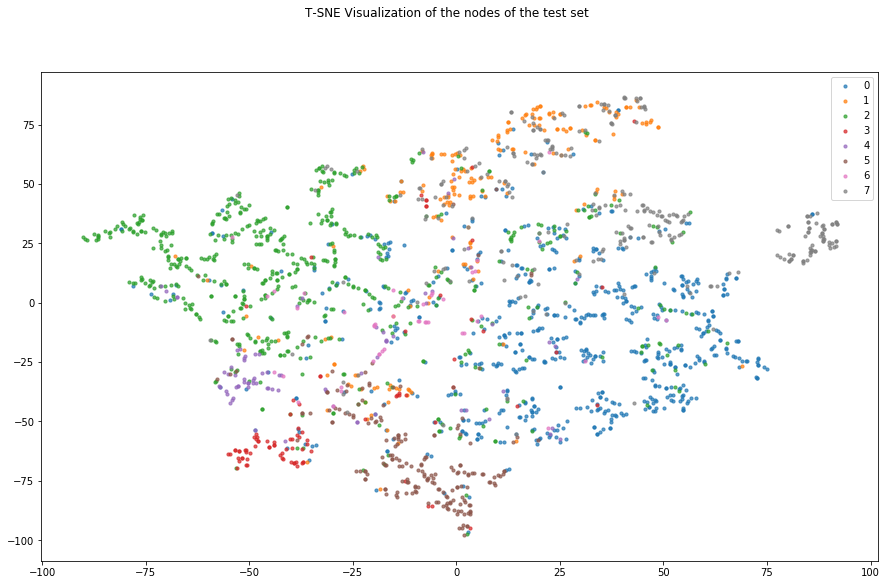

In [25]:

labels_ =labels[idx]
unique_labels = np.unique(labels_)

colors = ['C'+str(i) for i in np.arange(10)]

fig, ax = plt.subplots()
for i in range(len(unique_labels)):
    idxs = [j for j in range(len(labels_)) if labels_[j]==unique_labels[i]]
    ax.scatter(embeddings_test_2d[idxs,0], 
               embeddings_test_2d[idxs,1], 
               c=colors[i],
               label=i,
               alpha=0.7,
               s=10)

ax.legend(scatterpoints=1)
fig.suptitle('T-SNE Visualization of the nodes of the test set',fontsize=12)
fig.set_size_inches(15,9)
plt.show()

#Submission

In [0]:
from scipy.special import softmax

with open("test.csv", 'r') as f:
    test_hosts = f.read().splitlines()

idx_test=np.array([int(u) for u in test_hosts])
y_pred=softmax(embdings.detach().cpu().numpy()[idx_test])

In [0]:

with open('graph_baseline.csv', 'w') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    lst = list(le.inverse_transform(np.arange(8)))
    lst.insert(0, "Host")
    writer.writerow(lst)
    for i,test_host in enumerate(test_hosts):
        lst = y_pred[i,:].tolist()
        lst.insert(0, test_host)
        writer.writerow(lst)

# References
[1] https://github.com/rusty1s/pytorch_geometric

[2] https://rusty1s.github.io/pytorch_geometric/build/html/notes/introduction.html

[3] https://tkipf.github.io/graph-convolutional-networks/